In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#Get rid of SettingWithCopyWarnings
from sklearn.linear_model import LinearRegression
pd.options.mode.chained_assignment = None  
import scipy.stats as stats

In [2]:
roses = pd.read_csv('../Data/processedData/labeledBigRose.csv', sep='\t')

In [5]:
#First let's get a plot of average flowering date as a function of year. 
roses.head()

,Unnamed: 0,observer_id,login,name,photo_page_url,photo_url_square,photo_uuid,photo_id,extension,license,...,observed_on,quality_grade,taxon_id,taxon_name,rank,rank_level,active,ancestry,fileName,inBloom
0,0,1,kueda,Ken-ichi Ueda,https://www.inaturalist.org/photos/36944,https://inaturalist-open-data.s3.amazonaws.com...,638aecf7-f303-4f42-bee8-6e2517eb5798,36944,jpg,CC-BY,...,2011-06-10,research,78882,Rosa multiflora,species,10.0,True,48460/47126/211194/47125/47124/47132/47148/415...,D:\Roses\36944.jpg,True
1,1,2179,charlie,Charlie Hohn,https://www.inaturalist.org/photos/48170,https://inaturalist-open-data.s3.amazonaws.com...,c081b553-e6bf-4df7-9786-8f678a66583a,48170,jpg,CC-BY,...,2011-08-03,research,78882,Rosa multiflora,species,10.0,True,48460/47126/211194/47125/47124/47132/47148/415...,D:\Roses\48170.jpg,False
2,2,3773,anita363,Anita,https://www.inaturalist.org/photos/94456,https://inaturalist-open-data.s3.amazonaws.com...,ae5f0e5c-c848-415b-9b6a-81407dea87b9,94456,jpg,CC-BY-NC-SA,...,2006-05-25,research,78882,Rosa multiflora,species,10.0,True,48460/47126/211194/47125/47124/47132/47148/415...,D:\Roses\94456.jpg,True
3,3,2179,charlie,Charlie Hohn,https://www.inaturalist.org/photos/91270,https://inaturalist-open-data.s3.amazonaws.com...,c8067ae5-addc-485e-b2f3-c25b820d4920,91270,jpg,CC-BY,...,2012-03-18,research,78882,Rosa multiflora,species,10.0,True,48460/47126/211194/47125/47124/47132/47148/415...,D:\Roses\91270.jpg,False
4,4,3518,jwhittle,Jason Whittle,https://www.inaturalist.org/photos/106185,https://inaturalist-open-data.s3.amazonaws.com...,04d5ab90-176c-4cae-816e-b1746448637d,106185,jpg,CC-BY-NC-ND,...,2012-04-25,research,78882,Rosa multiflora,species,10.0,True,48460/47126/211194/47125/47124/47132/47148/415...,D:\Roses\106185.jpg,False


In [33]:
floweringDates = roses[roses['inBloom'] == True]['observed_on'].dropna().to_frame()

In [71]:
def days_since_start_of_year(month, day):
    days_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    days = sum(days_in_month[:month - 1]) + day
    if month > 2 and ((month <= 12 and month % 4 == 0 and month % 100 != 0) or (month % 400 == 0)):
        days += 1  # Leap year adjustment
    return days

def days_to_date(days):
    # Find the month and day corresponding to the average number of days
    days_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    for i, days_this_month in enumerate(days_in_month):
        if days <= days_this_month:
            return i + 1, int(days)
        days -= days_this_month
    return 12, int(days)


In [89]:
yearList = []
daysList = []
for i in floweringDates['observed_on']:
        yearList.append(int(i[:4]))
        daysList.append(days_since_start_of_year(int(i[5:7]), int(i[8:])))
floweringDates["Year"] = yearList
floweringDates['Days'] = daysList
uniqueYears = list(set(yearList))
uniqueYears.sort()
averageFloweringDays = []
for year in uniqueYears:
    averageFloweringDays.append(int(floweringDates[floweringDates["Year"] == year]['Days'].mean()))


In [98]:
model = LinearRegression()
model.fit(np.array(uniqueYears[6:-1]).reshape(-1,1), np.array(averageFloweringDays[6:-1]).reshape(-1,1))

LinearRegression()

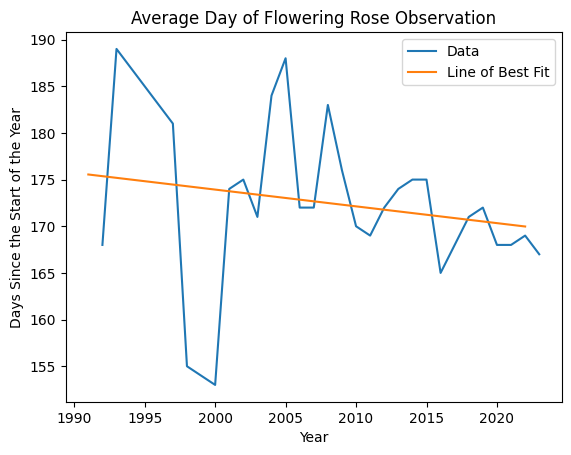

In [100]:
#There are a few outliers coming from the fact that those years have very few observations. We consider years between 1990 and before 2024. We plot a line of best fit as well.
plt.xlabel("Year")
plt.ylabel("Days Since the Start of the Year")
plt.title("Average Day of Flowering Rose Observation")
plt.plot(uniqueYears[6:-1], averageFloweringDays[6:-1], label="Data")
x_array = np.arange(1991, 2023, 1)
y_array = model.predict(x_array.reshape(-1,1))
plt.plot(x_array, y_array, label="Line of Best Fit")
plt.legend()

We can see that the trend is earlier and earlier in the year. We perform a two-sample t-test to determine whether the mean flowering day before 2020 is ealier than 2020 or later. This date was chosen in order to have a large number of data points both before and after it. 

In [113]:
beforeData = np.array(list(floweringDates[floweringDates["Year"] < 2020]['Days']))
afterData = np.array(list(floweringDates[floweringDates["Year"] >= 2020]['Days']))

# Print the variance of both data groups
print("Variances: ")
print(np.var(beforeData), np.var(afterData))
print("Means: ")
print(np.mean(beforeData), np.mean(afterData))

Variances: 
1824.5224733759042 1601.0642389124605
Means: 
171.505499276411 168.32639624640532


In [112]:
#We see the ratio < 4 so we can use a 2 sample t-test with equal variances. 
stats.ttest_ind(beforeData, afterData, equal_var=True)

TtestResult(statistic=8.39313697116405, pvalue=4.8095385208513527e-17, df=79888.0)

This is the two-sided p-value. Since the after mean is smaller then the one sided p-value would be 1/2 of this. We see that we can be relatively certain that the observed flowering date has gotten earlier in the year when we compare years before 2020 and those after 2019. 